In [1]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from utils import *
from permute.core import two_sample
from numpy.random import RandomState
from typing import Tuple

prng = RandomState(42)
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)

# Load data

In [2]:
df = load_to_df('data/twitter_data.json')
df = df[(df['timeline'] == 'Engagement') | (df['timeline'] == 'Chronological')]
df

100%|██████████| 1730/1730 [00:03<00:00, 528.09it/s]


,timeline,rank,prob_in_tl,user_id,user_summary_leaning,collected_at,shown_to_user,user_race,user_ethnicity,user_gender,...,full_text_len,tweet_age,partisanship,outgroup_animosity,outgroup_animosity_to_ingroup,outgroup_animosity_to_outgroup,ingroup_affect,outgroup_affect,user_time_key,user_summary_race
0,Engagement,1.0,1.0,341,1,2023-02-11 17:05:08.233,True,[White],[None of these],Man,...,23,1064.087217,0.0,0,0,0,0.0,0.0,341_2023-02-11 17:05:08.233,White
3,Engagement,2.0,1.0,341,1,2023-02-11 17:05:08.233,True,[White],[None of these],Man,...,136,501.270550,1.0,1,0,1,-1.0,-1.0,341_2023-02-11 17:05:08.233,White
4,Engagement,3.0,1.0,341,1,2023-02-11 17:05:08.233,True,[White],[None of these],Man,...,56,1195.270550,0.0,0,0,0,0.0,0.0,341_2023-02-11 17:05:08.233,White
7,Engagement,3.0,1.0,341,1,2023-02-11 17:05:08.233,True,[White],[None of these],Man,...,70,1195.703883,0.0,0,0,0,0.0,0.0,341_2023-02-11 17:05:08.233,White
10,Engagement,4.0,1.0,341,1,2023-02-11 17:05:08.233,True,[White],[None of these],Man,...,51,182.937217,0.0,0,0,0,0.0,0.0,341_2023-02-11 17:05:08.233,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282352,Chronological,90.0,1.0,165,-1,2023-02-28 05:55:47.757,False,[Asian],[None of these],Man,...,146,433.279283,0.0,0,0,0,0.0,0.0,165_2023-02-28 05:55:47.757,Asian or Native Hawaiian/other Pacific Islander
282353,Chronological,91.0,1.0,165,-1,2023-02-28 05:55:47.757,False,[Asian],[None of these],Man,...,132,386.279283,0.0,0,0,0,0.0,0.0,165_2023-02-28 05:55:47.757,Asian or Native Hawaiian/other Pacific Islander
282354,Chronological,92.0,1.0,165,-1,2023-02-28 05:55:47.757,False,[Asian],[None of these],Man,...,135,339.912617,0.0,0,0,0,0.0,0.0,165_2023-02-28 05:55:47.757,Asian or Native Hawaiian/other Pacific Islander
282355,Chronological,93.0,1.0,165,-1,2023-02-28 05:55:47.757,False,[Asian],[None of these],Man,...,169,284.829283,0.0,0,0,0,0.0,0.0,165_2023-02-28 05:55:47.757,Asian or Native Hawaiian/other Pacific Islander


# Distributions of tweet metadata

Calculates statistics for tweet metadata for each timeline.

In [3]:
def calculate_p_values(df, table_keys):
    p_values = {}
    for k in table_keys:
        chron_df = df[df['timeline'] == 'Chronological'][k]
        engagement_df = df[df['timeline'] == 'Engagement'][k]    
        p_val, _ = two_sample(chron_df, engagement_df, reps=10000, stat="mean", alternative="two-sided", seed=prng)
        p_values[k] = p_val
    return p_values

In [4]:
table_keys = [
    'tweet_age', 
    'favorite_count', 
    'retweet_count',
    'external_url_count',
    'photo_count',
    'video_count',
    'author_followers_count',
    'is_author_verified',
    'is_following',
]
    
p_values = calculate_p_values(df, table_keys)
def p_value(x):
    return p_values[x.name]

def percentile_5(series):
    # convert to float64 for boolean series
    return series.astype(np.float64).quantile(0.05)

def percentile_95(series):
    # convert to float64 for boolean series
    return series.astype(np.float64).quantile(0.95)

agg_dict = {k: ['mean', 'median', percentile_5, percentile_95, 'std', p_value] for k in table_keys}
summary_df = df.groupby('timeline').agg(agg_dict).transpose()

# Drop p-values for columns that are not "Chronological" or "Engagement"
for k in table_keys:
    summary_df['Stated Preference'][k]['p_value'] = None
    summary_df['Stated Preference with Downranking'][k]['p_value'] = None

summary_df

/var/folders/qc/bdvg83v530n09zhg0k9s7z_m0000gn/T/ipykernel_95135/2712245869.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df = df.groupby('timeline').agg(agg_dict).transpose()


timeline                              Chronological    Engagement  \
tweet_age              mean            8.637884e+03  3.641481e+03   
                       median          8.849123e+01  9.057769e+02   
                       percentile_5    3.727825e+00  1.886807e+01   
                       percentile_95   2.890509e+03  2.721355e+03   
                       std             1.413642e+05  8.996973e+04   
                       p_value         1.999800e-04  1.999800e-04   
favorite_count         mean            2.529138e+03  1.701773e+04   
                       median          3.800000e+01  7.740000e+02   
                       percentile_5    0.000000e+00  2.000000e+00   
                       percentile_95   7.476900e+03  8.417450e+04   
                       std             1.972290e+04  6.169772e+04   
                       p_value         1.999800e-04  1.999800e-04   
retweet_count          mean            3.947822e+02  1.787984e+03   
                       median          6.000000e+00  7.100000e+01   
                       percentile_5    0.000000e+00  0.000000e+00   
                       percentile_95   1.087000e+03  8.885950e+03   
                       std             7.812087e+03  1.287397e+04   
                       p_value         1.999800e-04  1.999800e-04   
external_url_count     mean            4.058478e-01  1.043568e-01   
                       median          0.000000e+00  0.000000e+00   
                       percentile_5    0.000000e+00  0.000000e+00   
                       percentile_95   1.000000e+00  1.000000e+00   
                       std             5.550658e-01  3.251171e-01   
                       p_value         1.999800e-04  1.999800e-04   
photo_count            mean            4.537378e-01  4.954675e-01   
                       median          0.000000e+00  0.000000e+00   
                       percentile_5    0.000000e+00  0.000000e+00   
                       percentile_95   2.000000e+00  2.000000e+00   
                       std             7.487745e-01  7.515628e-01   
                       p_value         1.999800e-04  1.999800e-04   
video_count            mean            1.326559e-01  1.864904e-01   
                       median          0.000000e+00  0.000000e+00   
                       percentile_5    0.000000e+00  0.000000e+00   
                       percentile_95   1.000000e+00  1.000000e+00   
                       std             3.392752e-01  3.895049e-01   
                       p_value         1.999800e-04  1.999800e-04   
author_followers_count mean            4.214753e+06  4.892968e+06   
                       median          1.513950e+05  9.510550e+04   
                       percentile_5    5.000000e+02  4.920000e+02   
                       percentile_95   2.575298e+07  1.945853e+07   
                       std             1.281964e+07  2.088920e+07   
                       p_value         1.999800e-04  1.999800e-04   
is_author_verified     mean            5.146500e-01  3.925222e-01   
                       median          1.000000e+00  0.000000e+00   
                       percentile_5    0.000000e+00  0.000000e+00   
                       percentile_95   1.000000e+00  1.000000e+00   
                       std             4.997869e-01  4.883157e-01   
                       p_value         1.999800e-04  1.999800e-04   
is_following           mean            6.992363e-01  5.686616e-01   
                       median          1.000000e+00  1.000000e+00   
                       percentile_5    0.000000e+00  0.000000e+00   
                       percentile_95   1.000000e+00  1.000000e+00   
                       std             4.585915e-01  4.952670e-01   
                       p_value         1.999800e-04  1.999800e-04   

timeline                              Stated Preference  \
tweet_age              mean                         NaN   
                       median                       NaN   
                       perc

## Plot long-tail distributions

In [5]:
PLOT_SETTINGS = [
    {
        'key': 'author_followers_count',
        'xlabel': 'Tweet Author\'s Number of Followers',
        'log_scale': True,
        'median': True,
    },
    {
        'key': 'favorite_count',
        'xlabel': 'Tweet\'s Number of Likes',
        'log_scale': True,
        'median': True,
    },
    {
        'key': 'retweet_count',
        'xlabel': 'Tweet\'s Number of Retweets',
        'log_scale': True,
        'median': True,
    },
    {
        'key': 'tweet_age',
        'xlabel': 'Tweet Age (minutes)',
        'log_scale': True,
        'median': True,
    }
]

def plot_hist(df: pd.DataFrame, ax: matplotlib.axes.SubplotBase, 
    key: str, xlabel: str, log_scale: bool, median: bool):
    df = df.copy()
    chronological_df = df[df['timeline'] == 'Chronological']
    personalized_df = df[df['timeline'] == 'Engagement']
    bins = min(50, len(df[key].unique()))
    if log_scale:
        df[key] += 1
    sns.histplot(data=df, x=key, alpha=0.5, bins=50, ax=ax, 
        hue='timeline', log_scale=log_scale)
    if median:
        chron_median = chronological_df[key].median()
        ax.axvline(chron_median, linestyle='--', color=sns.color_palette()[0])
        pers_median = personalized_df[key].median()
        ax.axvline(pers_median, linestyle='--', color=sns.color_palette()[1])
    ax.legend([],[], frameon=False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('')

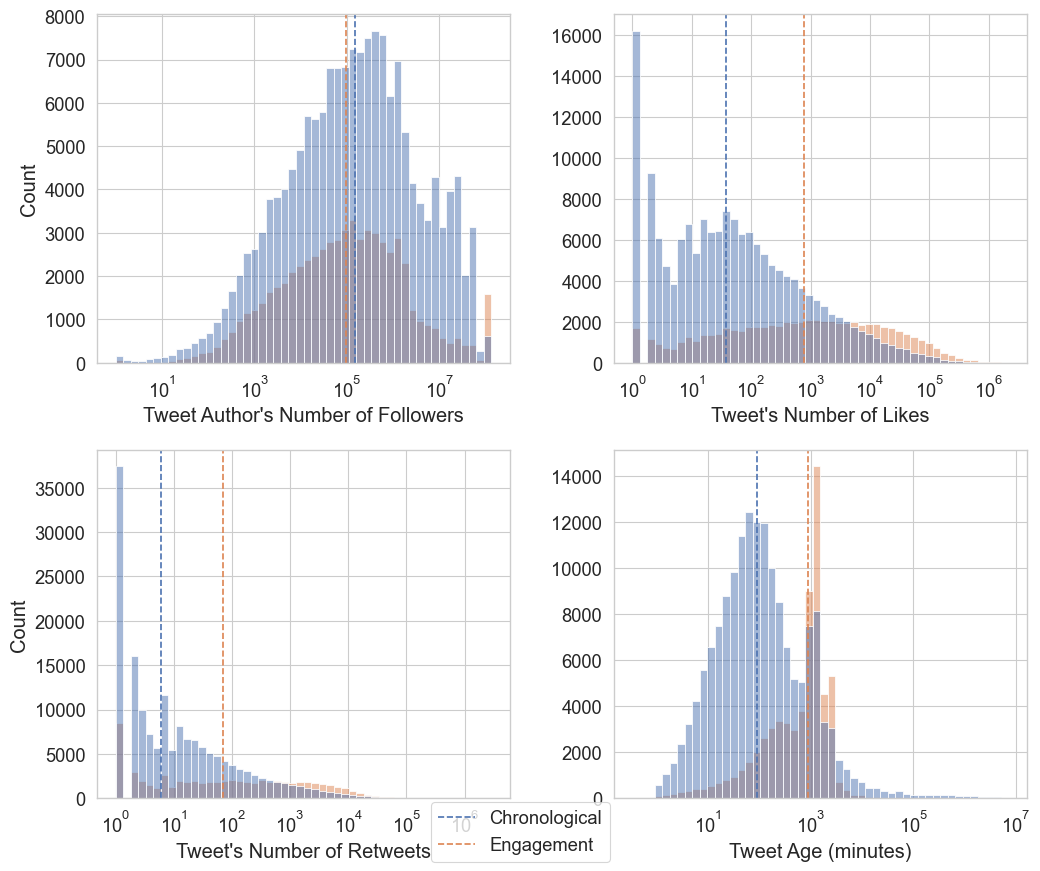

In [6]:
num_plots = len(PLOT_SETTINGS)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for ps, ax in zip(PLOT_SETTINGS, axes):
    plot_hist(df, ax, **ps)
axes[0].set_ylabel('Count')
axes[2].set_ylabel('Count')
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.25, wspace=0.25)
fig.legend(loc = 'lower center', labels=['Chronological', 'Engagement'])
fig.savefig('figures/metadata_stats.pdf', bbox_inches='tight')

# User-level amplification

Finds most amplified Twitter acounts per timeline.

In [7]:
num_to_show = 25
df['screen_name'] = '@' + df['screen_name']
chron_df = df[df['timeline'] == 'Chronological']
chron_users = chron_df.groupby('screen_name').size()
chron_users_top = chron_users.sort_values(ascending=False).head(num_to_show)
eng_df = df[df['timeline'] == 'Engagement']
eng_users = eng_df.groupby('screen_name').size()
eng_users_top = eng_users.sort_values(ascending=False).head(num_to_show)
amp_users_top = (eng_users-chron_users).sort_values(ascending=False).head(num_to_show)
amp_users_bot = (eng_users-chron_users).sort_values(ascending=True).head(num_to_show)

In [8]:
accounts_df = pd.DataFrame({
    'Chronological Top': chron_users_top.index,
    'Chronological Count': chron_users_top.values,
    'Highest in Engagement': eng_users_top.index,
    'Engagement Top': eng_users_top.values,
    'Most Amplified': amp_users_top.index,
    'Most Amplified Eng-Chron Diff': amp_users_top.values,
    'Least Amplified': amp_users_bot.index,
    'Least Amplified Eng-Chron Diff': amp_users_bot.values,
})
accounts_df

,Chronological Top,Chronological Count,Highest in Engagement,Engagement Top,Most Amplified,Most Amplified Eng-Chron Diff,Least Amplified,Least Amplified Eng-Chron Diff
0,@Reuters,1763,@elonmusk,1536,@elonmusk,1001.0,@Reuters,-1748.0
1,@nytimes,1451,@POTUS,321,@DailyLoud,108.0,@nytimes,-1297.0
2,@CNN,1207,@RonFilipkowski,224,@vidsthatgohard,94.0,@FatKidDeals,-1175.0
3,@FatKidDeals,1178,@JackPosobiec,196,@BornAKang,81.0,@CNN,-1078.0
4,@Wario64,1000,@fasc1nate,168,@HumansNoContext,80.0,@Wario64,-896.0
5,@NBA,871,@barstoolsports,165,@hodgetwins,76.0,@Forbes,-850.0
6,@Forbes,865,@DailyLoud,163,@stillgray,70.0,@AP,-810.0
7,@AP,847,@nytimes,154,@Dexerto,68.0,@NBA,-751.0
8,@FoxNews,732,@hodgetwins,141,@fasc1nate,60.0,@FoxNews,-658.0
9,@washingtonpost,723,@CNN,129,@krassenstein,59.0,@washingtonpost,-654.0


# % of tweets from different TLs for SP and SP-OA 

We calculate the percent of tweets for a particular timeline type (Stated Preference and Stated Preference with Downranking) that came from chronological vs. engagement-based timelines. Specifically, we look at tweets that came only from one of those timelines and from both timelines.

In [9]:
raw_df = load_to_df('data/twitter_data.json')

100%|██████████| 1730/1730 [00:02<00:00, 720.01it/s]


In [10]:
def pct_split_timeline(df: pd.DataFrame, tl_type: str) -> Tuple[float, float]:
    """
    Returns what % of tweets from the specified `tl_type` were taken from chronological
    and engagement, weighting by probabilities in the corresponding `prob_in_tl` column.
    
    Params:
        df: DataFrame with all tweets including Engagement, Chronological, Stated Preference,
            and Stated Preference with Downranking timeline types
        tl_type: string corresponding to timeline type, can either be "Stated Preference"
            or "Stated Preference with Downranking"
        
    Returns:
        Percent of tweets from only the chronological timeline, percent from only the engagement 
        timeline, and percent from both timelines.
    """
    assert tl_type in ('Stated Preference', 'Stated Preference with Downranking')
    
    # Filter based on timeline. We only need the tweet ids and the probability they are in the specified timeline.
    unique_eng_ids = set(df[df['timeline'] == 'Engagement']['id_str'])
    unique_chron_ids = set(df[df['timeline'] == 'Chronological']['id_str'])
    target_df = df[df['timeline'] == tl_type][['id_str', 'prob_in_tl']]
    
    from_chron, from_eng, from_both = 0, 0, 0
    for _, row in target_df.iterrows():
        id_str, prob_in_tl = row['id_str'], row['prob_in_tl']
        
        # Add up weights from specified `tl_type`
        if id_str in unique_eng_ids and id_str in unique_chron_ids:
            from_both += prob_in_tl
        elif id_str in unique_eng_ids and id_str not in unique_chron_ids:
            from_eng += prob_in_tl
        elif id_str not in unique_eng_ids and id_str in unique_chron_ids:
            from_chron += prob_in_tl
        else:
            raise Exception(f"Tweet id {id_str} in neither chron or eng timelines")

    # Normalize
    total = from_both + from_chron + from_eng
    
    print("Percent of tweets only from the chronological timeline: {:.2f}%".format(100 * from_chron / total))
    print("Percent of tweets only from the engagement timeline: {:.2f}%".format(100 * from_eng / total))
    print("Percent of tweets from both timelines: {:.2f}%".format(100 * from_both / total))

## Stated preference timeline

In [11]:
pct_split_timeline(raw_df, 'Stated Preference')

Percent of tweets only from the chronological timeline: 43.47%
Percent of tweets only from the engagement timeline: 33.98%
Percent of tweets from both timelines: 22.55%


## Stated preference with downranking timeline

In [12]:
pct_split_timeline(raw_df, 'Stated Preference with Downranking')

Percent of tweets only from the chronological timeline: 43.79%
Percent of tweets only from the engagement timeline: 33.97%
Percent of tweets from both timelines: 22.24%


# Average overlap between timelines

We determine the average number of tweets that overlapped between the chronological and engagement-based timelines.

In [13]:
def get_tl_overlap_per_user_time_key(df: pd.DataFrame) -> float:
    """
    Returns average overlap between Chronological and Engagement timelines over a specified
    `user_id_key`.
    
    Params:
        df: DataFrame with just Chronological and Engagement tweets
    
    Returns:
        Average count of tweets that overlap between the timelines for each user_id_key
    """
    # We only want main tweets so that we don't double-count tweets that are replied or quoted
    df = df[df['tweet_type'] == 'main_tweet']
    
    unique_user_time_keys = set(df['user_time_key'])
    overlap = 0
    
    for key in unique_user_time_keys:
        # Fetch tweet ids per timeline for the specified user_time_key
        chron_ids = df.loc[(df['timeline'] == 'Chronological') & (df['user_time_key'] == key), 'id_str']
        eng_ids = df.loc[(df['timeline'] == 'Engagement') & (df['user_time_key'] == key), 'id_str']
        
        # Count overlap
        overlap += len(eng_ids[eng_ids.isin(chron_ids)])
        
    return overlap / len(unique_user_time_keys)

In [14]:
avg_overlap = get_tl_overlap_per_user_time_key(df.copy())
print(f"Average tweet overlap: {avg_overlap}")

Average tweet overlap: 6.505780346820809
